In [1]:
import sys
print(sys.version)

3.7.4 (default, Aug 13 2019, 20:35:49) 
[GCC 7.3.0]


In [2]:
import cv2
import glob
import numpy as np
from IPython.display import Image


## Task 1: Pinhole camera model and calibration
https://docs.google.com/document/d/1ICOuXPzNbGSG0eNyMCZUArUQ9a8uhqBODID1ZDELYFw/edit#heading=h.rahbroakbdke

### Step (1): Load the images. 
Please use the images in the provided resource files. For this task, the folder is "images/task_1". Since a stereo camera system is used, there are two sets of images with prefixes of "left_" and "right_", indicating which camera took the images. You are going to calibrate each individual camera separately, i.e., if you want to calibrate the left camera, use those images with prefixes of "left_". You can use the OpenCV library function "imread()" for this step.


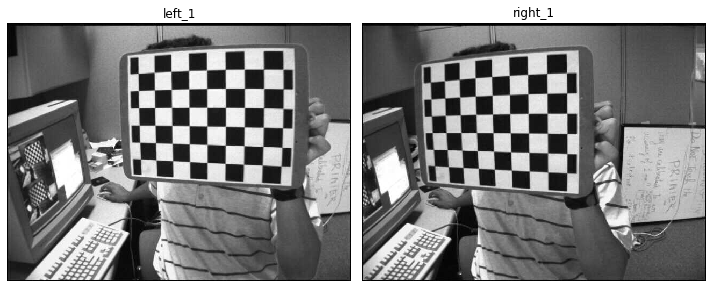

In [38]:
# left_ = [cv2.imread(image) for image in sorted(glob.glob("../../images/task_1/left_*.png"))]
# right_ = [cv2.imread(image) for image in sorted(glob.glob("../../images/task_1/right_*.png"))]

left_ = [cv2.imread(image) for image in sorted(glob.glob("../../images/opencv_sample_calibration_images/left*"))]
right_ = [cv2.imread(image) for image in sorted(glob.glob("../../images/opencv_sample_calibration_images/right*"))]

import matplotlib.pyplot as plt
def plot_figures(figures, nrows=1, ncols=1):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows, figsize=(10,10))
    if(nrows > 1 or ncols > 1):
        for ind,title in enumerate(figures):
            axeslist.ravel()[ind].imshow(figures[title], cmap=plt.gray())
            axeslist.ravel()[ind].set_title(title)
            axeslist.ravel()[ind].set_axis_off()
        plt.tight_layout() # optional
    else:
        for ind,title in enumerate(figures):
            axeslist.imshow(figures[title], cmap=plt.gray())
            axeslist.set_title(title)
            axeslist.set_axis_off()
            

plot_figures({'left_1': left_[0], 'right_1': right_[0]}, 1, 2)

### Step (2): Extract 3D-to-2D point correspondences. 
For each image with the calibration board pattern, you are going to extract the corner points on the image using OpenCV library function `findChessboardCorners()`. These are the 2D points. The 3D points are just (0, 0, 0), (1, 0, 0), (2, 0, 0), ..., (n, 0, 0), (0, 1, 0), (1, 1, 0), (2, 1, 0), ..., (n, 1, 0), (0, 2, 0), ..., (n, 2, 0), ..., (n, m, 0), where the number of calibration board corners are n by m. These 3D points use a reference frame on the board with one grid cell as unit length. Note that the provided images use a calibration board of 9 by 6, and each square cell has a width and height of 25.4 mm, i.e., exactly one inch. If you want to use the actual scale, you can just multiply the 3D coordinates with the actual cell length (e.g., in meters or millimeters). However, a single camera can not reliably recover the scale of the actual imaged objects. Also note that the detected corner points on the board are sorted row by row in a numpy array in Python or an STL vector in C++ (from red to blue if you draw them on the image), so the correspondences are already there as the 3D points are known. Note that you may use all the images for calibration or just a subset of them. Usually 3 to 10 images are enough, but using only one image may not provide satisfying results.


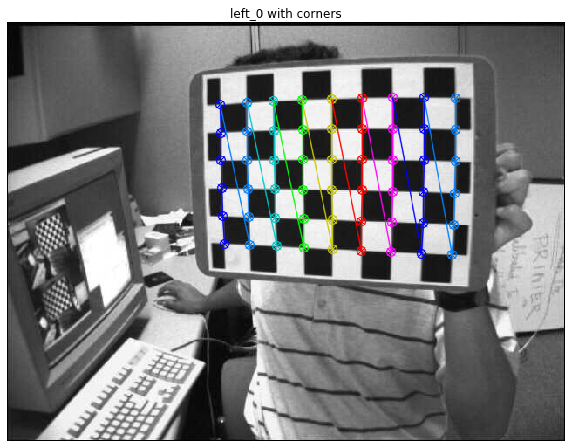

In [39]:
retval, corners_2D = cv2.findChessboardCorners(left_[0],(6,9))
# print(retval,corners_2D)

corner_img = left_[0].copy()
cv2.drawChessboardCorners(corner_img,(6,9),corners_2D,retval)
plot_figures({'left_0 with corners': corner_img})

In [40]:
corners2 = cv2.cornerSubPix(gray,corners_2D,(11,11),(-1,-1),criteria)
np.array_equal(np.array(corners_2D),np.array(corners2))

True

### Step (3): Calculate camera intrinsic parameters.
Once the 3D-to-2D point correspondences are obtained, call OpenCV library function [`calibrateCamera()`](https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#calibratecamera) to calculate the camera intrinsic matrix and distort coefficients. 

True True True True True True True True True True True True True True True True True True True True True True True True True True 

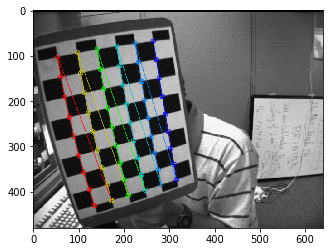

In [42]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

rows = 6
# columns = 7   # doesn't work
# columns = 8
columns = 9

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(columns,5,0)
objp = np.zeros((columns*rows,3), np.float32)
objp[:,:2] = np.mgrid[0:columns,0:rows].T.reshape(-1,2)
objp = objp*25.4

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

images = left_ + right_

for img_og in images:
    img = img_og.copy()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (columns,rows),None)
    print(ret,end=' ')
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)   # this does not do anything
        imgpoints.append(corners2)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (columns,rows), corners2,ret)
        plt.imshow(img)
#         cv2.imshow('img',img)
#         cv2.waitKey(500)

# cv2.destroyAllWindows()

In [43]:
ret, mtx, distCoeffs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

img = images[0].copy()
h,  w = img.shape[:2]
newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,distCoeffs,(w,h),1,(w,h))

### Step (4): Check the calibration results.
After the camera parameters are obtained, you can undistort the images of calibration board patterns with these parameters using OpenCV library function "initUndistortRectifyMap()" and "remap()". An example is shown in Figure 3. Note that on the undistorted image, the lines of the chessboard pattern are straight. This is expected since 3D-to-2D projective transformation maintains line straightness.

In [44]:
newcameramtx

array([[443.45303345,   0.        , 338.13769045],
       [  0.        , 439.19000244, 241.6655003 ],
       [  0.        ,   0.        ,   1.        ]])

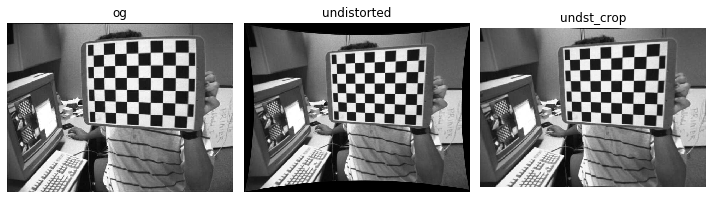

In [45]:
dst = cv2.undistort(img, mtx, distCoeffs, None, newcameramtx)

# crop the image
x,y,w,h = roi
dst_crop = dst[y:y+h, x:x+w]

plot_figures({'og':img, 'undistorted':dst, 'undst_crop':dst_crop},1,3)

### Step (5): Save the parameters to a file.
You can use OpenCV "FileStorage" class to write the intrinsic matrix and distort coefficients into a single XML file, or you can just use NumPy "savetxt()" to write them into multiple CSV files if you choose to use Python. These parameters should be saved for future use. In the next tasks, You can use the same OpenCV "FileStorage" class to read out the saved camera parameters.

In [ ]:
s = cv2.FileStorage('./calibrated_camera_parameters.xml', cv2.FileStorage_WRITE)

In [ ]:
s.write('mtx', mtx)
s.write('distCoeffs', distCoeffs)
s.write('newcameramtx', newcameramtx)
s.write('roi', roi)

In [ ]:
s.release()